# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
#

In [1]:
# packages for data wrangling
import string
import pandas as pd
import re
# packages for webscrapping
import requests
from bs4 import BeautifulSoup
#packages for sentiment Analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from gensim import corpora, models
# packages for visualizations
#import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 50
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

In [ ]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

In [ ]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [2]:
df = pd.read_csv("data/BA_reviews.csv")

In [3]:
# dirty and untidy data affects analysis and results.
# this function should clean most of the data quality issues 
def preprocess_reviews(reviews):
    # remove punctuation
    reviews = reviews.translate(str.maketrans('', '', string.punctuation))
    
    # convert to lowercase
    reviews = reviews.lower()

    # remove numbers
    reviews = re.sub(r'\d+', '', reviews)

    # remove special characters
    reviews = re.sub(r'[^\x00-\x7F]+', '', reviews)

    # remove whitespaces
    reviews = reviews.strip()

    return reviews


# Apply the preprocessing function to the reviews column
df['reviews'] = df['reviews'].apply(preprocess_reviews)

In [4]:
# let's remove reviews that aren't verified
df = df[~df['reviews'].str.contains("not verified", case=False) & ~df['reviews'].str.contains("unverified", case=False)]

In [5]:
#let's stripped out "trip verified" tags from the reviews
df['reviews'] = df['reviews'].str.replace("trip verified", "")

In [6]:
# sentimentIntensityAnalyzer lib will help run the sentiment analyzes,it does the tokenization and dropping stop words
def sentiment_analysis(df, reviews):
    sentiment_analyzer = SentimentIntensityAnalyzer()
    sentiments = []
    for review in df['reviews']:
        sentiment = sentiment_analyzer.polarity_scores(review)['compound']
        if sentiment >= 0.05:
            sentiments.append('positive')
        elif sentiment <= -0.05:
            sentiments.append('negative')
        else:
            sentiments.append('neutral')
    return sentiments

sentiments = sentiment_analysis(df, 'reviews')
df['sentiment']= sentiments 
# Output: ['positive', 'negative', 'neutral']

In [7]:
df

,Unnamed: 0,reviews,sentiment
0,0,ba on the boarding was delayed due to late...,positive
1,1,not only my first flight in years but also...,positive
2,2,my husband and myself were flying to madrid...,positive
3,3,organised boarding process really friendly c...,positive
4,4,outward journey ba london to buenos aires c...,negative
...,...,...,...
3466,3466,flight from heathrow to toronto booked emergen...,negative
3467,3467,lhr to ham purser addresses all club passenger...,positive
3468,3468,my son who had worked for british airways urge...,positive
3469,3469,london citynew york jfk via shannon on a but h...,positive


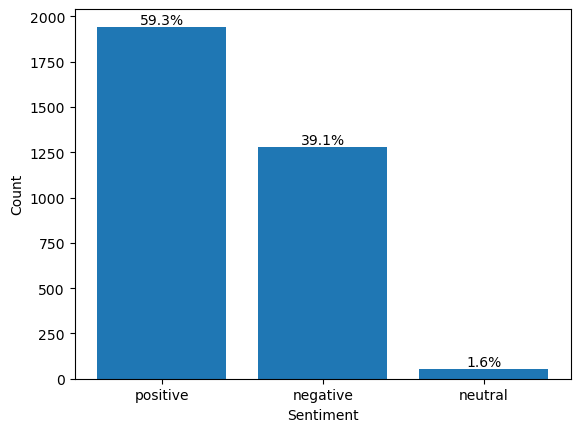

In [8]:
# i'd count up the positives and negatives and draw a sentiment distribution
# Count the number of occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment distribution
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Count")

# Add the percentage of each bar to the plot
total = len(df)
for i in range(len(sentiment_counts)):
    percent = sentiment_counts.values[i] / total * 100
    plt.annotate("{:.1f}%".format(percent), (sentiment_counts.index[i], sentiment_counts.values[i]), ha='center', va='bottom')

plt.show()

## Word Cloud

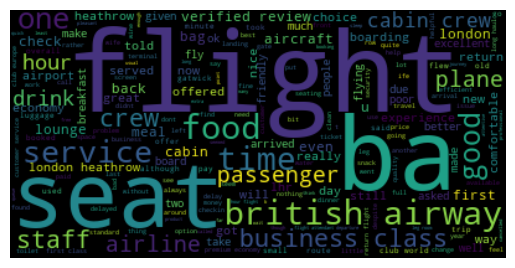

In [9]:
# i'll try to visulaize the most frequently used word in the reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# joining the reviews into a single string
all_reviews = " ".join(df['reviews'])

# this generates the word cloud
wordcloud = WordCloud().generate(all_reviews)

# plotting the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Topic Modelling

In [10]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df)
profile.to_file("profile_output.html")

c:\ProgramData\Anaconda3\envs\british_airways\lib\multiprocessing\pool.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  iterable = list(iterable)
C:\Users\PC\AppData\Local\Temp\ipykernel_11448\473227740.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  profile = ProfileReport(df)
C:\Users\PC\AppData\Local\Temp\ipykernel_11448\473227740.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  profile = ProfileReport(df)


TypeError: concat() got an unexpected keyword argument 'join_axes'

In [10]:
docs = df.reviews.tolist()
docs[0]

'  ba  on the  boarding was delayed due to late arrival from the incoming flight communication from the ground staff was excellent and keep us informed in flight services were excellent the crews were friendly with excellent service overall very happy with ba'

In [12]:
import top2vec
#from top2vec import Top2Vec

ContextualVersionConflict: (numpy 1.24.2 (c:\programdata\anaconda3\envs\british_airways\lib\site-packages), Requirement.parse('numpy<1.24,>=1.18'), {'numba'})

In [ ]:
# Download NLTK stopwords
# nltk.download('stopwords')

In [ ]:
from nltk.corpus import stopwords
# Tokenize the reviews
stop_words = set(stopwords.words('english'))
df['tokens'] = df['reviews'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words])

# Create a dictionary from the tokenized reviews
dictionary = corpora.Dictionary(df['tokens'])

# Create a corpus from the dictionary and tokenized reviews
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Train an LDA model
num_topics = 5
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)


In [ ]:
# Visualize the LDA model using a topic proportion bar chart
doc_topic_dist = [lda_model.get_document_topics(doc) for doc in corpus]
topic_props = [[topic[1] for topic in doc] for doc in doc_topic_dist]
topic_names = [f'Topic {i}' for i in range(num_topics)]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(topic_names, [sum(props) / len(topic_names) for props in zip(*topic_props)])
ax.set_title('Topic Proportions')
ax.set_xlabel('Topics')
ax.set_ylabel('Proportion')
for i, v in enumerate([sum(props) / len(topic_names) for props in zip(*topic_props)]):
    ax.text(i - 0.1, v + 0.01, str(round(v, 2)))

plt.show()

In [ ]:
# importing libraries
import gensim
from gensim.corpora import Dictionary

In [ ]:
# having processed the reviews earlier, we jump straight converting to list
reviews_data = [review.split() for review in df['reviews']]
#df['reviews'].tolist()

# Create a dictionary of words from the text data
dictionary = Dictionary(reviews_data)

# Convert the data into bag-of-words representation
bow_corpus = [dictionary.doc2bow(reviews) for reviews in reviews_data]

# training the LDA model
num_topics = 5
lda_model = gensim.models.LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary)

# Print the top words for each topic
for topic_id, topic in lda_model.print_topics():
    print("Topic #%d:" % topic_id)
    print(" ".join([word[0] for word in topic[1].split(" + ")]))

In [ ]:
for topic in lda_model.print_topics(num_words=5):
    print(topic)

In [ ]:
# Visualize the LDA model using a topic proportion bar chart
doc_topic_dist = [lda_model.get_document_topics(doc) for doc in bow_corpus]
topic_props = [[topic[1] for topic in doc] for doc in doc_topic_dist]
topic_names = [f'Topic {i}' for i in range(num_topics)]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(topic_names, [sum(props) / len(topic_names) for props in zip(*topic_props)])
ax.set_title('Topic Proportions')
ax.set_xlabel('Topics')
ax.set_ylabel('Proportion')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Get the topic distribution for each document
doc_topic_dist = [lda_model.get_document_topics(doc) for doc in bow_corpus]

# Create a list of topic proportions for each document
topic_props = [[topic[1] for topic in doc] for doc in doc_topic_dist]

# Create a list of topic names
topic_names = [f'Topic {i}' for i in range(num_topics)]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(topic_names, [sum(props) / len(topic_names) for props in zip(*topic_props)])
ax.set_title('Topic Proportions')
ax.set_xlabel('Topics')
ax.set_ylabel('Proportion')
plt.show()


In [ ]:
# to visualize the model
import pyLDAvis.gensim

# Visualize the LDA model
visuals = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(visuals)

## text Similarity
Here, i'll try to determine the similarity between customers reviews based on the content of the reviews.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Convert the text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df["reviews"])

# Calculate the cosine similarity between all customer reviews
similarity = cosine_similarity(tfidf)

# Display the cosine similarity matrix
print(similarity)
